In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))
display(HTML(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIRD parameter learning using FISTA with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [L^2(0,1)]^3} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|_2^2 + \frac{\vartheta}{2} \| \rho(T) - \widehat{\rho}(T) \|^2_{\R^3},
\end{align}
where $\rho = (\begin{smallmatrix} \sigma & I & R \end{smallmatrix})$ comes from the solution of a change of variables applied to the Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameters $\theta$ and $\vartheta$ are non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each pair of parameters $\alpha = (\beta, \gamma, m) \in [0,1]^3$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \tag{$\star$}
\begin{aligned}
    \frac{\dif \sigma}{\dif t} &= a_1\beta (\mathsf{n} - \sigma) I,
    \\
    \frac{\dif I}{\dif t} &= a_1\beta (\mathsf{n} - \sigma) I - (a_2\gamma + a_3 m) I,
    \\
    \frac{\dif R}{\dif t} &= a_2\gamma I,
    \\
    \frac{\dif D}{\dif t} &= a_3 m I.
\end{aligned}
\end{align}
We note that $ \mathsf{n} $ is the total population at the start of the study.
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import gurobipy as GRB
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, exp, ones, eye, empty, append, diagflat, tril, triu
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals, inv
from scipy.integrate import simpson, trapezoid
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline, interp1d
from scipy.sparse.linalg import LinearOperator
from scipy.sparse    import eye as speye
from scipy.sparse    import bmat
from numpy.polynomial.chebyshev import chebpts1
from matplotlib import colormaps

# Model scaling

We scale the baseline original ODE system for the SIRD model. Assuming $\overline{\rho}(\tau)$ satisfies the original SIRD ODE system above with parameters $\overline\alpha = (\overline\beta, \overline\gamma, \overline{m})$ and initial condition $\overline{\rho}_0$, then $(\star)$ above is related with $\overline{\rho}$ via the relationships

* Population scaling: $\overline{\rho} = s_1 \rho$, where $ \rho_{\mathsf{S}} = \mathsf{n} - \sigma $,

* Time scaling: $\tau = s_2 t$,

* Parameter scalings: $\overline{\alpha} = \left( \frac{a_1}{s_1 s_2} \beta, \frac{a_2}{s_2} \gamma, \frac{a_3}{s_2} m \right)$.

# Data loading

We load data used in [[1]](https://doi.org/10.1016/j.rico.2023.100346). Locally, we have stored data of susceptible, infected, recovered, and deceased compartments from June 1 – July 20, 2021. When constructing the dataset, the total population size $\mathsf{n}$ was set to 164\,689\,383 given by an estimate from [[3]](https://www.worldometers.info/world-population/bangladesh-population/). We will set $\mathsf{n}$ to be equal to the total number of people at the initial time.

In [4]:
SIRD_data = pd.read_pickle('BD_2021_Jun_Jul.pkl').values.astype('float64')

In [5]:
print('𝗇̄: {0:.0f}'.format(np.unique(SIRD_data.sum(1)).item()))

𝗇̄: 164689383


In [6]:
σ_data = SIRD_data.sum(1) - SIRD_data[:,0]

In [7]:
ΣIRD_data = np.c_[σ_data, SIRD_data[:,1:]]      # Determine σ and remove S compartment

In [8]:
int(ΣIRD_data.max()), int(SIRD_data.max())      # There is quite a difference in order of magnitude

(22887, 164686226)

The data considers reports spanning 60 days. 

In [9]:
T = np.float64(ΣIRD_data.shape[0])

**Scales**

We will group the observations by week and label the initial week by $0$; i.e., $s = 7$ and $T = 50/7 \approx 7$. We will scale people by the maximum expected value of the residual susceptibles $\sigma$:

In [10]:
time_scale = 7.0                 # s_2
ppl_scales = ΣIRD_data.max();    # s_1

In [11]:
T /= time_scale                        # Scale time
ΣIRD_data /= ppl_scales                # Scale population: (helps in computation time)

In [12]:
# Make an interval span
Tᵒᵇˢ  = linspace(0,T,SIRD_data.shape[0])

We build a piecewise interpolator for computing any integral terms:

In [13]:
Tₑ = 0.5*(chebpts1(152-2+1)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])         # Add endpoints
# Add observed points
Tₑ = np.unique(np.sort(concatenate([Tₑ,Tᵒᵇˢ])))

In [14]:
Tₑ.size    # odd number of collocation points for Simpson

201

In [15]:
ρ̄ = interp1d(Tᵒᵇˢ,ΣIRD_data[:,].T, axis=-1, kind = 'quadratic')
ρ̂ = ρ̄(Tₑ)

In [16]:
ρ̄(0).sum()

0.3132782802464281

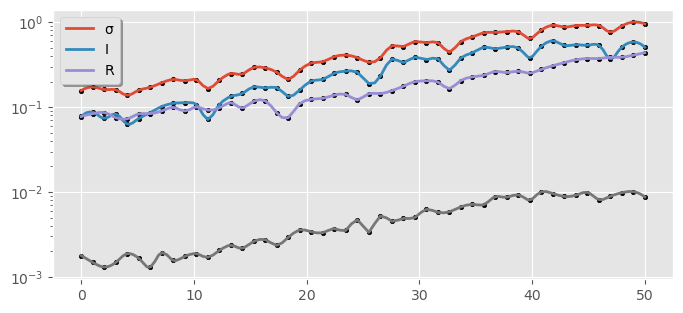

In [17]:
# Plot data
plt.figure(figsize=(8,3.5))

plt.plot(Tₑ*time_scale, ρ̂.T, '-', linewidth=2)
for i in range(4):
    plt.scatter(Tᵒᵇˢ*time_scale, ΣIRD_data[:,i], s=10, c='black')
plt.yscale('log')

plt.legend(['σ', 'I', 'R'], shadow=True)
plt.show()

Compare numerical ranges for different scales:

In [18]:
# Original data:
lows = np.min(SIRD_data, 0);    ups  = np.max(SIRD_data, 0);    strs = ['S̄', 'Ī', 'R̄', 'D̄']
for i in range(4):
    print('{0:9.0f} ≤ {1:s} ≤ {2:.0f}'.format(lows[i], strs[i], ups[i]))

164666496 ≤ S̄ ≤ 164686226
     1447 ≤ Ī ≤ 13768
     1667 ≤ R̄ ≤ 9997
       30 ≤ D̄ ≤ 231


In [19]:
# Scaling by total population is not that good:
lows = np.min(SIRD_data, 0)/SIRD_data[0].sum();    ups  = np.max(SIRD_data, 0)/SIRD_data[0].sum();    strs = ['S̄', 'Ī', 'R̄', 'D̄']
for i in range(4):
    print('{0:.4e} ≤ {1:s} ≤ {2:.4e}'.format(lows[i], strs[i], ups[i]))

9.9986e-01 ≤ S̄ ≤ 9.9998e-01
8.7862e-06 ≤ Ī ≤ 8.3600e-05
1.0122e-05 ≤ R̄ ≤ 6.0702e-05
1.8216e-07 ≤ D̄ ≤ 1.4026e-06


In [20]:
# σIR data is well behaved:
lows = np.min(ΣIRD_data, 0);    ups  = np.max(ΣIRD_data, 0);    strs = ['σ̄', 'Ī', 'R̄', 'D̄']
for i in range(4):
    print('{0:.3f} ≤ {1:s} ≤ {2:.3f}'.format(lows[i], strs[i], ups[i]))

0.138 ≤ σ̄ ≤ 1.000
0.063 ≤ Ī ≤ 0.602
0.073 ≤ R̄ ≤ 0.437
0.001 ≤ D̄ ≤ 0.010


We see that the $\sigma \mathsf{IR}$ model is better scaled by compartment and explicitly shows the evolution of $\sigma$. In contrast, the susceptible compartment in the original model might give the impression that it is a constant.

### Prior information

In the original paper, the authors obtained the following constant–in–time estimates:

In [21]:
print('β̂: {0:.15f}, γ̂: {1}, m̂: {2}'.format(0.0706 / 164689383, 0.0257, 0.0011))

β̂: 0.000000000428686, γ̂: 0.0257, m̂: 0.0011


Using the current scales, we obtain the better behaved values:

In [22]:
print('β̂: {0:.8f}, γ̂: {1}, m̂: {2}'.format(ppl_scales * time_scale * 0.0706 / 164689383, time_scale * 0.0257, time_scale * 0.0011))

β̂: 0.00006868, γ̂: 0.1799, m̂: 0.0077


We notice that $\beta$ and $\gamma$ are still very small. So we can use $a_1 = 10^{-4}$, $a_2 = 1$, and $a_3 = 10^{-2}$ to obtain:

In [23]:
aᵦ = 1e-4;    aᵧ = 1.0;    aₘ = 1e-2
print('β̂: {0:.8f}, γ̂: {1}, m̂: {2}'.format(ppl_scales * time_scale * 0.0706 / (164689383 * aᵦ), time_scale * 0.0257/aᵧ, time_scale * 0.0011/aₘ))

β̂: 0.68679323, γ̂: 0.1799, m̂: 0.77


### Bounds

Without bounds, the range of each parameter at any given time is given by:

In [24]:
print('uᵦ: {0:.0f}, uᵧ: {1:.0f}, uₘ: {2:.0f}'.format(ppl_scales * time_scale / aᵦ, time_scale / aᵧ, time_scale / aₘ))

uᵦ: 1602090000, uᵧ: 7, uₘ: 700


Knowing that $\beta$ has at least 9 zeros, let us impose the upper bound $\overline{\beta} = 10^{-9}$ (which is about the inverse of the order of magnitude of the total population). Similarly, let us bound $\gamma$ and $\beta$ by $10^{-1}$:

In [25]:
print('uᵦ: {0:.2f}, uᵧ: {1:.2f}, uₘ: {2:.0f}'.format(1e-9 * ppl_scales * time_scale / aᵦ, 0.1 * time_scale / aᵧ, 0.01 * time_scale / aₘ))

uᵦ: 1.60, uᵧ: 0.70, uₘ: 7


In [26]:
SIRD_data[0].sum() / ppl_scales

7195.761043387076

# Problem setup

Total population, initial condition, and terminal condition:

In [27]:
# Total population
#n = ρ̄(0).sum()
n = SIRD_data[0].sum() / ppl_scales
# Initial conditions
ρ̂ₒ = ρ̄(0)
# Final time
ρ̂ᶠ = ρ̄(T)

Weights in loss:

In [28]:
θ, ϑᵀᵉʳ = 1e-6, 0.1

In [29]:
θ = np.asarray([1e-9,1e-9,1e-9])#[::,np.newaxis]

Upper bounds on parameters:

In [30]:
upper_b = (np.asarray([1e-9, 0.1, 0.01]) * [ ppl_scales * time_scale / aᵦ, time_scale / aᵧ, time_scale / aₘ])#[::,np.newaxis]
print(upper_b.T)

[1.60209 0.7     7.     ]


In [31]:
upper_b.ravel() * asarray([aᵦ/(time_scale*ppl_scales),aᵧ/(time_scale),aₘ/time_scale])

array([1.e-09, 1.e-01, 1.e-02])

In [32]:
1e-1 * asarray([aᵦ/(time_scale*ppl_scales),aᵧ/(time_scale),aₘ/time_scale])

array([6.24184659e-11, 1.42857143e-02, 1.42857143e-04])

## Differential systems

In [33]:
α = np.array([0.07364913, 0.184188 , 0.3663371])

### Solve a state:

In [34]:
def SIRD(t, z,  α):
    β, γ, m = [aᵦ,aᵧ,aₘ] * α    # Scale parameters
    S, I, R, D = z
    return [β*(n-S)*I, β*(n-S)*I - γ*I - m*I, γ*I, m*I]

In [35]:
sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=[α], t_eval = Tₑ, dense_output=True, vectorized=True, rtol = 1e-10)
print(sol['message'],'There were',sol.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 32 function evaluations.


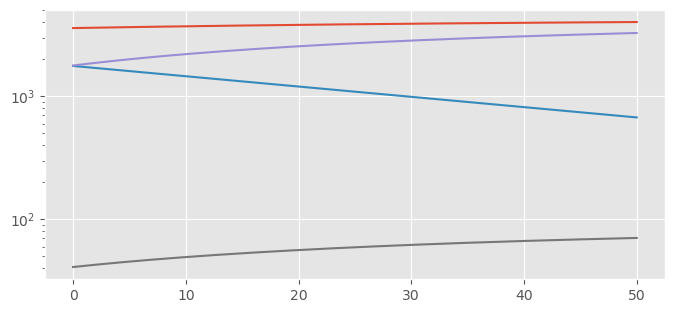

In [36]:
# Plot solution:
plt.figure(figsize=(8,3.5))
#plt.plot(Tₑ,n-sol.y[0].T)
plt.plot(Tₑ * time_scale, sol.y.T * ppl_scales)
#plt.yscale('symlog', linthresh=1e-1)
#plt.xscale('symlog', linthresh=1e-2)
plt.yscale('log')
plt.plot();

At this step we can also test the scalings:

In [37]:
ω = α * [aᵦ/ (ppl_scales * time_scale), aᵧ/time_scale, aₘ/time_scale]

In [38]:
ω,α

(array([4.59706571e-11, 2.63125714e-02, 5.23338714e-04]),
 array([0.07364913, 0.184188  , 0.3663371 ]))

In [39]:
def SIRDn(t, z,  α):
    β, γ, m = α    # Scale parameters
    S, I, R, D = z
    return [β*(ppl_scales*n-S)*I, β*(ppl_scales*n-S)*I - γ*I - m*I, γ*I, m*I]

In [40]:
sol_original_scale = solve_ivp(SIRDn, [0, T*time_scale], ppl_scales * ρ̂ₒ, args=(ω,), 
                                                   t_eval = Tₑ*time_scale, dense_output=True, vectorized=True, rtol=1e-6)
print(sol_original_scale['message'])

The solver successfully reached the end of the integration interval.


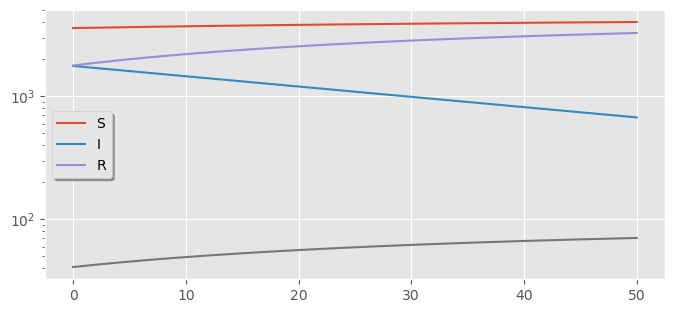

In [41]:
# Plot solution:
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ * time_scale, sol_original_scale.y.T)
#plt.yscale('symlog', linthresh=1e-2)
#plt.xscale('symlog', linthresh=1e-2)
plt.yscale('log')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.show()

## Solve its adjoint

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_\sigma}{\dif t} &= \hat{\sigma} - \sigma + [a_1 \beta] I (q_\sigma + q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I - [a_1 \beta] (n-\sigma)(q_\sigma + q_I) + [a_2\gamma] (q_I - q_R) + [a_3 m] (q_I - q_D),
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
    \\
    \frac{\dif q_D}{\dif t} &= \hat{D} - D,
\end{align}
with the terminal condition $q(T) = \vartheta\big[\rho(T) - \widehat{\rho}(T)\big]$.

In [42]:
# Interpolator from ODE
ρₜ = sol.sol
ρ = sol.y

In [43]:
dw = simpson((ρ̂ - (simpson((ρ̂), x=Tₑ)/T)[::,np.newaxis])**2, x = Tₑ) ** -1    # Goodness of fit weight

In [44]:
def Adjoint(t, z, α,ρ):
    β, γ, m    = [aᵦ,aᵧ,aₘ] * α      # Use scaled interpolator
    S̄, Ī, R̄, D̄ = dw * ρ̄(t)           # Target
    S, I, R, D = dw * ρ(t)           # State
    qₛ, qᵢ, qᵣ, qᵈ = z           # Adjoint
    return [S̄ - S + β*I*(qₛ + qᵢ), Ī - I - β*(n-S)*(qₛ + qᵢ) + γ*(qᵢ - qᵣ) + m * (qᵢ - qᵈ), R̄ - R, D̄ - D]

In [45]:
qₒ = ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)
solₛ = solve_ivp(Adjoint, [T,0], qₒ, args=(α,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
q = solₛ.y[:,::-1]
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 80 function evaluations.


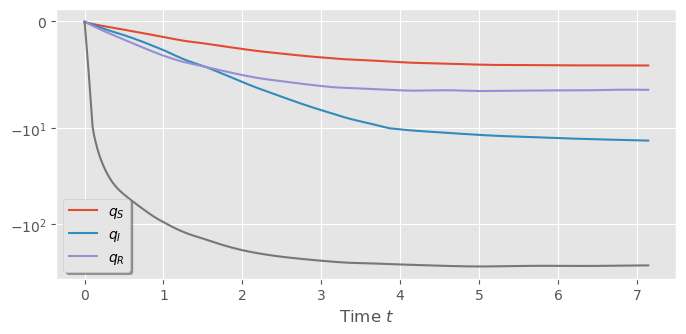

In [46]:
# Plot adjoint curves
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ[::-1],q.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
#plt.yscale('log')
plt.yscale('symlog', linthresh=1e1)
plt.show()

## Cost and gradient

Let us evaluate the function
\begin{align}
    j(\alpha) = \frac{1}{2} \int\limits_0^T w_1 \big( \sigma(t) - \hat{\sigma}(t) \big)^2 +  w_2 \big( I(t) - \hat{I}(t) \big)^2 + w_3 \big( R(t) - \hat{R}(t) \big)^2 + w_4 \big( D(t) - \hat{D}(t) \big)^2 \,\dif t  +  \frac{1}{T} \big( \theta_1 \beta^2 + \theta_2 \gamma^2 + \theta_3 m^2 \big)  + \frac{1}{2} \| \vartheta (\rho(T) - \widehat{\rho}(T)) \|^2_{\R^3}
    .
\end{align}

In [47]:
def Objective(ρ,ρ̂,α, θ,ϑᵀᵉʳ,  scale = 1.0):
    # State + controls
    s  = (dw * simpson((ρ-ρ̂)**2, x=Tₑ)).sum()  +  (ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)**2).sum()
    s *= scale
    # Controls
    s +=  (α**2 * θ).sum() / T
    # Weight
    s *= 0.5
    return s

In [48]:
print('As an example, the objective value for α is {0:.4e}.'.format(  Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ, scale = (1) ) ))

As an example, the objective value for α is 3.9747e+00.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T a_1 (n-\sigma) I( q_\sigma + q_I ) \dif t  + \theta_1 \beta
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T a_2 I( q_R - q_I ) \dif t  + \theta_2 \gamma
    \\
    \frac{\partial f}{\partial m} &= \int\limits_0^T a_3I (q_D - q_I) \dif t   + \theta_3 m
\end{align}

In [49]:
df = asarray([aᵦ * simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), aᵧ * simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), aᵧ * simpson(ρ[1] * (q[3]-q[1]), x=Tₑ)])  + (θ/T) * α

In [50]:
print(df)

[-3.53180650e-05  1.34500692e+00 -7.77370112e+01]


### Define projection

In [51]:
def proj(α):    return np.clip(α, 0.0, upper_b)

In [52]:
proj( 7000 * (1-α - 0.82))

array([1.60209, 0.     , 0.     ])

# A few evaluations

Let us evaluate the objective for some curves:

In [53]:
global ρ, q
ρ = np.zeros_like(ρ̂)
q = np.zeros_like(ρ̂)

In [54]:
# Increase tolerance: Quasi-Newton methods are generally more susceptible to numerical errors
# 1e-3 is the default tolerance of the solver, 1e-4 produces fair results and this is replicated in 1e-6
rt = 1e-9
# Scale the population compartments by some quantity; e.g., n^-2 scales by total number of people at time 0
scaling = True
scale = 1.0 if scaling else 1.0

def obj_eval(α):                  # ** Eval f and f' ** #
    global ρ, q, df
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρ  = ρ_sol.y
    f  = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ,  scale)
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)    # Terminal condition
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False, rtol=rt)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df = scale * asarray([ aᵦ * simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), 
                           aᵧ * simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), 
                           aᵧ * simpson(ρ[1] * (q[3]-q[1]), x=Tₑ)]) 
    df += (θ/T) * α
    
    return asarray(f), df
def obj_eval_a(α):                # ** Eval just f ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρ  = ρ_sol.y
    f  = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ,  scale)
    
    return asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρₐ = ρ_sol.y
    f  = Objective(ρₐ,ρ̂,α, θ, ϑᵀᵉʳ,  scale)

    return asarray(f)
def obj_eval_d(α):                # ** Does not affect global variables ρ, q, df ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    
        print('Should re-evaluate.')
        plt.plot(ρ_sol.y.T)
        plt.show()
        print(ρ_sol)
    ρᵦ = ρ_sol.y
    f  = Objective(ρᵦ,ρ̂, α, θ, ϑᵀᵉʳ,  scale)
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ * (ρᵦ[:,-1] - ρ̂ᶠ)    # Terminal condition
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False, rtol=rt)
    qᵦ = q_sol.y[:,::-1]

    # Compute derivative
    dF = scale * asarray([ aᵦ * simpson(ρᵦ[0]*ρᵦ[1] * (qᵦ[1]-qᵦ[0]), x=Tₑ),    
                           aᵧ * simpson(ρᵦ[1] * (qᵦ[2]-qᵦ[1]), x=Tₑ),    
                           aₘ * simpson(ρᵦ[1] * (qᵦ[3]-qᵦ[1]), x=Tₑ) ])
    dF += (θ/T) * α

    return asarray(f), dF

In [55]:
obj_eval_a(α)

array(3.97471049)

---

# Solving the optimisation problem

We will use a gradient-based algorithm for optimising $f$. For any $L > 0$, and $\omega \in [0,1]^2$, define the the operator
$$
    p_L (\omega) := \mathcal{P}_{[0,1]^2}[\omega - L^{-1} \nabla f(\omega) ].
$$

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Fast Iterative Shrinkage-Thresholding Algorithm</h2>
<ol>
<li>Let $\alpha_0 = \omega_0 \in [0,1]^2$, $\theta_0 = 1$, $L_0>0$, $\eta > 1$, and $a < 1$.</li>
<li>
    For any $L>0$ and $\alpha,\omega \in [0,1]^2$, define the functions
    \begin{align}
        p_L (\omega) &= \mathcal{P}_{[0,1]^2}[\omega - L^{-1} \nabla f(\omega) ],
    \\
        q_L (\omega,\alpha) &= f(\alpha) + \langle \omega-\alpha, \nabla f(\alpha) \rangle + \frac{L}{2} \|\omega-\alpha\|^2.
    \end{align}
</li>
    
<li>For $k \in \{0,\ldots\}$, do
<ol>
<li>Compute state $\rho_{\omega_k}$
<li>Compute adjoint $q_{\omega_k}$
<li>Evaluate the gradient of the reduced functional $ \nabla f(\omega_k)$

<li>Find the smallest $i_k \in \mathbb{N}$ such that
\begin{align}
    L &= \eta^{i_k} L_k
    \\
    f\big( p_L (\omega_k) \big) &\leq q_L \big( p_L(\omega_k), \omega_k  \big)
\end{align}
    
<li>Update $L_{k+1} = \eta^{i_k} L_k$
<li>Set $\alpha_{k+1} = p_{L_{k+1}} (\omega_k)$
<li>Update $\theta_{k+1} = a k + 1$
<li>Update $\omega_{k+1} = \alpha_{k+1} + \frac{\theta_k - 1}{\theta_{k+1}} (\alpha_{k+1} - \alpha_k)$
</li>
</ol>
</div>

## Algorithm

In [56]:
#scale = 1e-0 #1e-4
scale

1.0

In [57]:
def box_scale(x,y):
    '''
        Return minimum value of scalar s > 0  such that x + sy ∈ [0,1] for x ∈ [0,1]
    '''
    a = np.divide(x, y, where=(y>0))[y>0]
    b = np.divide((x-1), y, where=(y<0))[y<0]
    if len(a) > 0:
        if len(b) > 0:
            return min( a.min(), b.min() )
        else:
            return a.min()
    else:
        return b.min()

In [58]:
def FISTA(α, iters, save_iter = False, critical = 1, εₐ = 1e-9, εᵦ = 1e-16, try_TR = False):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 'β':[], 'γ':[], 'm':[], 'df_β':[], 'df_γ':[], 'df_m':[],
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    
    '''
        GD iterates
    '''
    print('     It  |    f(ω)  |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    # Initialisation
    # 1.1, 0.965, 10, 11/5   [0.259914]
    # 1.01, 0.965, 10, 11/5  [0.107911]
    # Best so far
    # 1.01 0.1 10 11/5 [0.100978]
    
    ω = α.copy()
    θₖ = 1.0      # Inertia parameter (not to be confused with \theta)
    η = 1.01     # Scaling for backtracking
    L = 0.965     # Approximation of the Lipschitz constant
    I = 40       # Number of iterations for backtracking
    a = 11.0/5   # Inertia weight (a > 2)
    
    # First objective evaluation
    # Compute state and adjoint for ω
    f = obj_eval_a(α)
    
    timed = 0.0
    for k in range(iters):
        #print(L)
        α_o = α.copy()
        θ_o = θₖ
        f_o = f
        
        it_time = time.time()
        
        # Compute state and adjoint for ω
        f, df = obj_eval(ω)
        
        # Store info for initial point
        if k == 0 and save_iter:
            every_iter['it'].append( k-1 )
            every_iter['obj'].append( f )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['m'].append( α[2] )
            every_iter['df_β'].append( df[0] )
            every_iter['df_γ'].append( df[1] )
            every_iter['df_m'].append( df[2] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(df)/(3**0.5) )
            every_iter['norms']['ℓ_1'].append( (1/3) * norm(df,1) )
            every_iter['norms']['max'].append( norm(df,np.inf) )
            every_iter['norms']['min'].append( abs(df).min() )
        
        
        # Create scale factor is derivative is too far away from [0,1]^3:
        # In other words: go one step ahead if α - s * df goes too far, backtracking will waste time!
        bₜ = box_scale(α,df)
        s  = 0.1/norm(df) if norm(df,np.inf) > 1.0 else 1.0
        s = s if bₜ <= 0.0 else max(bₜ,s)
        
        # Backtracking
        for i in range(I):
            # Temporary approximation of Lipschitz constant
            Lₓ = η**i * L
            b  = 1.0/Lₓ
            # Gradient and proximal step
            u = ω - (b * s) * df
            p = proj(u)
            # Compute state to validate Lₓ
            fₖ = obj_eval_a(p)
            # Validation step
            if fₖ <= f + (p - ω).dot(df) + 0.5 * (Lₓ/s) * norm(p - ω)**2:
                break
        
        # Update control
        #L = Lₓ
        α = p.copy()
        # Update inertia
        θₖ = ((k+1)/a) + 1.0
        ω = α + (θ_o - 1) * ( α - α_o )/θₖ
        if (ω < 0.0).any():
            #print('hey', ω)
            # Infeasible point is projected back into the box
            ω = proj(ω)
        
        Exit = True
        '''if L > 1e+4:
            print('Here')
            θₖ = (a/(k+1))
            η = 1.01     # Scaling for backtracking
            L = 0.965     # Approximation of the Lipschitz constant
            I = 20       # Number of iterations for backtracking
            a = 11.0/5   # Inertia weight (a > 2)
            #α = α_o.copy()
            α = ω.copy()
            Exit = False'''
            #break
        
                
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        if save_iter:
            every_iter['it'].append( k )
            every_iter['obj'].append( fₖ )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['m'].append( α[2] )
            every_iter['df_β'].append( df[0] )
            every_iter['df_γ'].append( df[1] )
            every_iter['df_m'].append( df[2] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(df)/(3**0.5) )
            every_iter['norms']['ℓ_1'].append( (1/3) * norm(df,1) )
            every_iter['norms']['max'].append( norm(df,np.inf) )
            every_iter['norms']['min'].append( abs(df).min() )
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( fₖ )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(df)/(3**0.5) )
            every_critical['|df|_max'].append( norm(df,np.inf) )
            
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        f, timed,
                                                                        norm(df)/(3**0.5), 
                                                                        norm(df,np.inf) ))
        
        if abs(f - f_o) < εᵦ and k > 10:
            print('|f-fₖ| < {0:1.0e}'.format(εᵦ))
            break
        
        if norm(α - α_o)/(2.0**0.5) < εₐ:
            print('‖αₖ - p‖ < {0:1.0e}'.format(εₐ))
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    # Due to nonmonoticity, last iterate is not necessarily the best candidate
    idx = np.argmin(every_iter['obj'])
    α = asarray([every_iter['β'][idx], every_iter['γ'][idx], every_iter['m'][idx]])
    jα = obj_eval_a(α)
    print(α,jα)
    
    return α, ρ, every_critical, every_iter

In [59]:
from sklearn.metrics import r2_score

In [60]:
ᾱ, ρ, every_critical, every_iter = FISTA(α, iters=10000, save_iter = True, critical = 50)

     It  |    f(ω)  |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  4.0e+00 |     0.07  | 4.565e+01   |   7.906e+01  
*     50 |  3.3e+00 |     3.84  | 1.032e+01   |   1.787e+01  
*    100 |  4.2e+00 |     7.52  | 8.417e+01   |   1.458e+02  
*    150 |  3.7e+00 |    10.99  | 4.160e+01   |   7.203e+01  
*    200 |  4.2e+00 |    14.45  | 6.291e+01   |   1.090e+02  
*    250 |  3.9e+00 |    18.09  | 6.184e+01   |   1.071e+02  
*    300 |  3.9e+00 |    21.56  | 4.871e+01   |   8.436e+01  
*    350 |  3.6e+00 |    25.10  | 9.336e-01   |   1.285e+00  
*    400 |  3.5e+00 |    28.55  | 1.889e+01   |   3.267e+01  
*    450 |  3.6e+00 |    31.96  | 2.846e+01   |   4.925e+01  
*    500 |  3.7e+00 |    35.45  | 1.985e+01   |   3.435e+01  
*    550 |  4.2e+00 |    39.02  | 8.041e+01   |   1.393e+02  
*    600 |  3.3e+00 |    42.41  | 1.905e+01   |   3.296e+01  
*    650 |  4.3e+00 |    45.91  | 5.707e+01   |   9.885e+01  
*    70

*   6550 |  7.9e-01 |   503.44  | 1.435e+02   |   2.485e+02  
*   6600 |  7.6e-01 |   507.47  | 1.384e+02   |   2.396e+02  
*   6650 |  7.3e-01 |   511.50  | 1.338e+02   |   2.316e+02  
*   6700 |  7.1e-01 |   515.50  | 1.318e+02   |   2.283e+02  
*   6750 |  7.1e-01 |   519.52  | 1.335e+02   |   2.312e+02  
*   6800 |  7.3e-01 |   523.52  | 1.380e+02   |   2.390e+02  
*   6850 |  7.6e-01 |   527.57  | 1.430e+02   |   2.477e+02  
*   6900 |  7.8e-01 |   531.57  | 1.461e+02   |   2.531e+02  
*   6950 |  7.8e-01 |   535.57  | 1.458e+02   |   2.526e+02  
*   7000 |  7.6e-01 |   539.52  | 1.425e+02   |   2.467e+02  
*   7050 |  7.2e-01 |   543.52  | 1.378e+02   |   2.386e+02  
*   7100 |  6.9e-01 |   547.49  | 1.341e+02   |   2.322e+02  
*   7150 |  6.8e-01 |   551.53  | 1.332e+02   |   2.306e+02  
*   7200 |  6.9e-01 |   555.47  | 1.356e+02   |   2.348e+02  
*   7250 |  7.1e-01 |   559.48  | 1.401e+02   |   2.425e+02  
*   7300 |  7.3e-01 |   563.52  | 1.445e+02   |   2.502e+02  
*   7350

In [61]:
print(1 - (simpson((ρ-ρ̂)**2, x=Tₑ) * dw), '  ', r2_score(ρ̂,ρ, sample_weight=dw))

[0.92804866 0.81707445 0.95780141 0.91571566]    0.9580914439125355


In [76]:
ᾱ, ρ, every_critical, every_iter = FISTA(array([1.6, 0.5, 2.]), iters=10000, save_iter = True, critical = 100)

     It  |    f(ω)  |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  5.6e+02 |     0.12  | 1.250e+04   |   2.090e+04  
*    100 |  4.4e+01 |     6.98  | 2.184e+02   |   3.782e+02  
*    200 |  2.3e+01 |    15.35  | 1.111e+02   |   1.923e+02  
*    300 |  1.2e+01 |    24.57  | 2.179e+02   |   3.689e+02  
*    400 |  5.5e+00 |    33.79  | 1.158e+02   |   1.971e+02  
*    500 |  3.5e+00 |    42.05  | 1.056e+02   |   1.827e+02  
*    600 |  2.5e+00 |    50.19  | 4.674e+01   |   8.096e+01  
*    700 |  2.1e+00 |    58.62  | 5.975e+00   |   1.031e+01  
*    800 |  1.9e+00 |    66.48  | 2.468e+01   |   4.266e+01  
*    900 |  1.9e+00 |    74.81  | 3.642e+01   |   6.294e+01  
*   1000 |  2.0e+00 |    82.83  | 5.092e+01   |   8.804e+01  
*   1100 |  1.6e+00 |    90.73  | 1.348e+02   |   2.333e+02  
*   1200 |  1.2e+00 |    98.96  | 1.332e+02   |   2.308e+02  
*   1300 |  2.7e+00 |   107.34  | 6.038e+00   |   9.959e+00  
*   140

In [77]:
print(1 - (simpson((ρ-ρ̂)**2, x=Tₑ) * dw), '  ', r2_score(ρ̂,ρ, sample_weight=dw))

[0.93301375 0.84120977 0.96258087 0.92098656]    0.9616344047992774


In [78]:
simpson((ρ-ρ̂)**2, x=Tₑ).sum(),  ϑᵀᵉʳ * ((ρ[:,-1] - ρ̂ᶠ)**2) 

(0.072482472611796,
 array([9.11233346e-04, 1.37126375e-03, 6.15167464e-05, 9.98649271e-07]))

In [79]:
((ρ[:,-1] - ρ̂ᶠ))

array([ 0.09545854,  0.11710097, -0.02480257,  0.00316014])

---

In [80]:
#CMap = get_cmap('Wistia')
CMap = colormaps['RdPu']
colours_nmAPG = CMap(150)

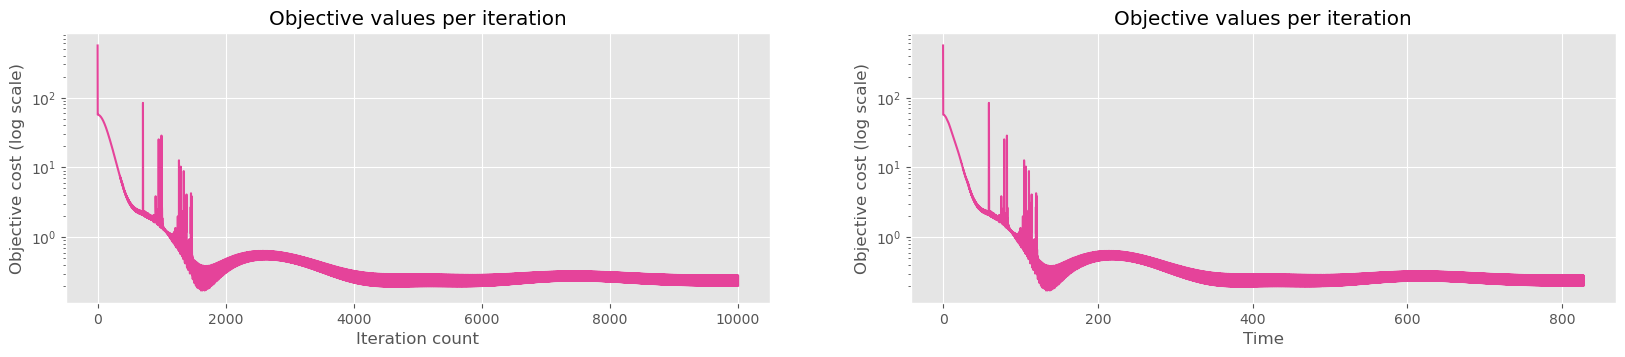

In [81]:
# Visualise evolution of objective values
plt.figure(figsize = (20,3.5))

plt.subplot(1, 2, 1)
#plt.plot(every_iter['obj'] - min(every_iter['obj']), c = colours_nmAPG)
plt.plot(every_iter['obj'] , c = colours_nmAPG)
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] , c = colours_nmAPG)
#plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']), c = colours_nmAPG)
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

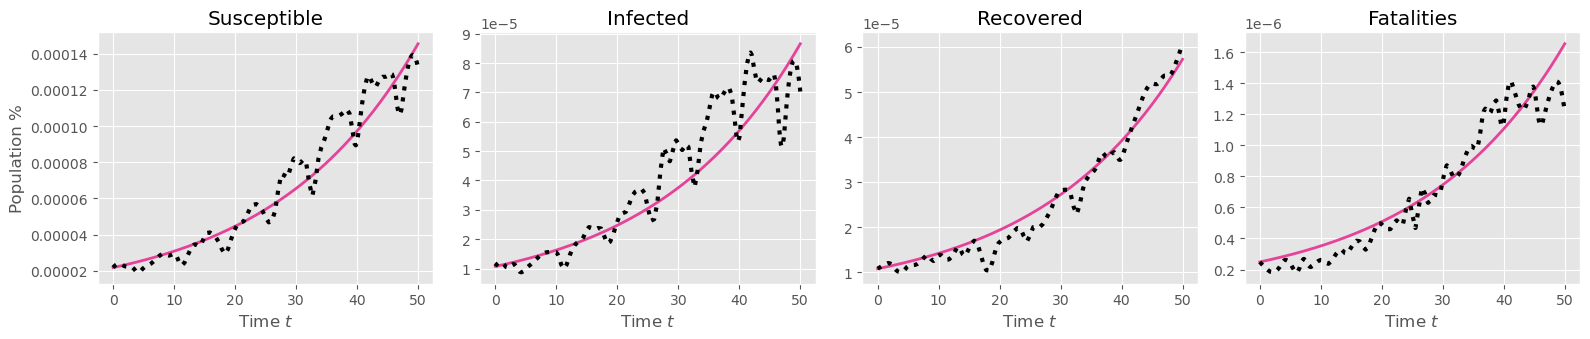

In [82]:
# Plot state 
fig, ax = plt.subplots(1, 4, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, ρ[0]/n, '-', c=colours_nmAPG, linewidth=2)
ax[1].plot(Tₑ*7, ρ[1]/n, '-', c=colours_nmAPG, linewidth=2)
ax[2].plot(Tₑ*7, ρ[2]/n, '-', c=colours_nmAPG, linewidth=2)
ax[3].plot(Tₑ*7, ρ[3]/n, '-', c=colours_nmAPG, linewidth=2)
    
# Add target
ax[0].plot(Tₑ*7, ρ̂[0]/n, ':', c='black', linewidth=3)
ax[1].plot(Tₑ*7, ρ̂[1]/n, ':', c='black', linewidth=3)
ax[2].plot(Tₑ*7, ρ̂[2]/n, ':', c='black', linewidth=3)
ax[3].plot(Tₑ*7, ρ̂[3]/n, ':', c='black', linewidth=3)

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')
ax[3].set_xlabel(r'Time $t$');    ax[3].set_title(r'Fatalities')

ax[0].set_ylabel('Population %')

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

In [83]:
obj_eval(ᾱ);

In [84]:
df

array([-2.69475569e-05,  1.42671846e+00,  1.18471717e+01])

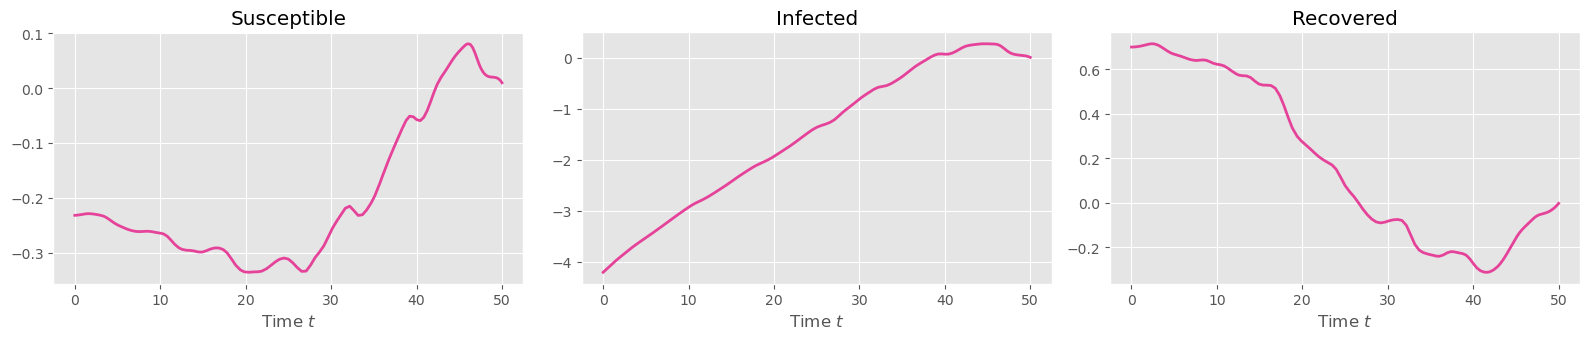

In [85]:
# Plot adjoint
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, q[0], '-', c=colours_nmAPG, linewidth=2)
ax[1].plot(Tₑ*7, q[1], '-', c=colours_nmAPG, linewidth=2)
ax[2].plot(Tₑ*7, q[2], '-', c=colours_nmAPG, linewidth=2)
    

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')



#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

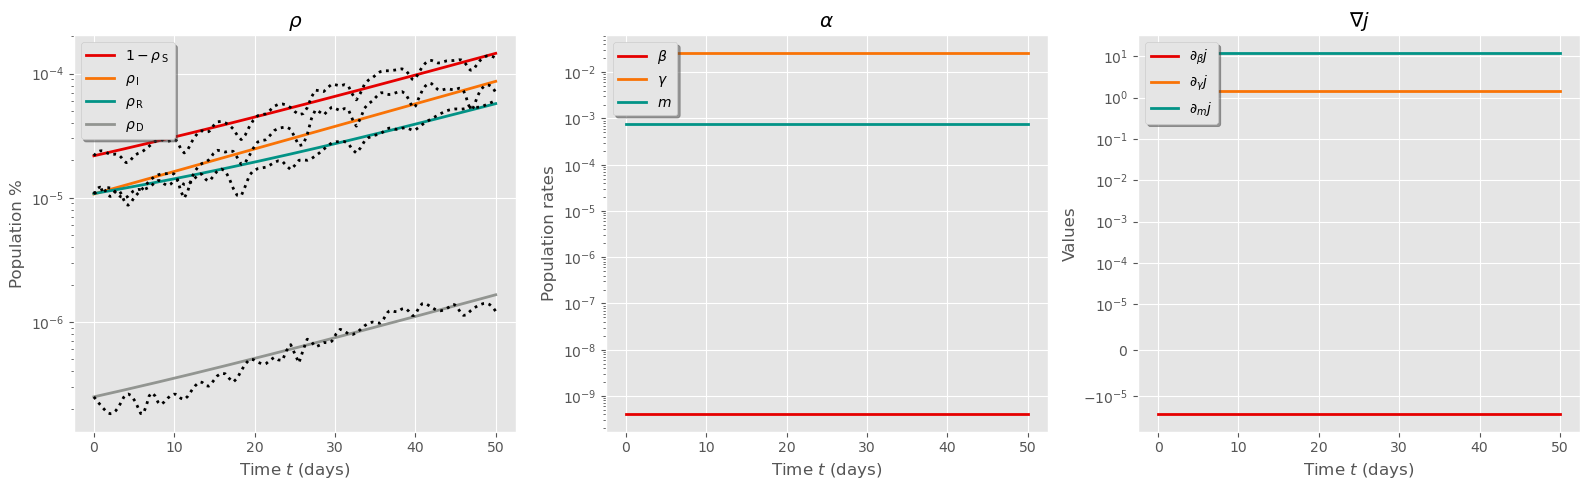

In [86]:
# Plot state 
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
colors = ['xkcd:red','xkcd:orange','xkcd:teal','xkcd:gray']

# Add state
ax[0].plot(Tₑ*7, ρ[0].T * ppl_scales / SIRD_data[0].sum(), '-', linewidth=2)
ax[0].plot(Tₑ*7, ρ[1:].T* ppl_scales / SIRD_data[0].sum(), '-', linewidth=2)
for i, line in enumerate(ax[0].get_lines()):    line.set_color(colors[i])
ax[0].legend(['$1-ρ_{\,\mathsf{S}}$', '$ρ_{\,\mathsf{I}}$', '$ρ_{\,\mathsf{R}}$', '$ρ_{\,\mathsf{D}}$'], shadow=True, loc='upper left')

ax[0].plot(Tₑ*7, ρ̂[0].T * ppl_scales/SIRD_data[0].sum(), ':', c='black', linewidth=2)
ax[0].plot(Tₑ*7, ρ̂[1:].T* ppl_scales/SIRD_data[0].sum(), ':', c='black', linewidth=2)

ax[1].plot(Tₑ*7, ᾱ[0]*aᵦ/(time_scale*ppl_scales) * ones(Tₑ.size), '-', c='xkcd:red', linewidth=2)   #scale to original units
ax[1].plot(Tₑ*7, ᾱ[1]*aᵧ/time_scale * ones(Tₑ.size), '-', c='xkcd:orange', linewidth=2)
ax[1].plot(Tₑ*7, ᾱ[2]*aₘ/time_scale * ones(Tₑ.size), '-', c='xkcd:teal', linewidth=2)
ax[1].legend(['$β$', '$γ$', '$m$'], shadow=True, loc='upper left')

ax[2].plot(Tₑ*7, df[0]  * ones(Tₑ.size), '-', c='xkcd:red', linewidth=2)
ax[2].plot(Tₑ*7, df[1] * ones(Tₑ.size), '-', c='xkcd:orange', linewidth=2)
ax[2].plot(Tₑ*7, df[2] * ones(Tₑ.size), '-', c='xkcd:teal', linewidth=2)
ax[2].legend(['$\partial_β j$', '$\partial_γ j$', '$\partial_m j$'], shadow=True, loc='upper left')


ax[0].set_xlabel(r'Time $t$ (days)');    ax[0].set_title(r'$\rho$')
ax[1].set_xlabel(r'Time $t$ (days)');    ax[1].set_title(r'$\alpha$')
ax[2].set_xlabel(r'Time $t$ (days)');    ax[2].set_title(r'$\nabla j$')

ax[0].set_ylabel('Population %')
ax[1].set_ylabel('Population rates')
ax[2].set_ylabel('Values')

ax[0].set_yscale('log')#, linthresh=1e-2)
ax[1].set_yscale('log')
#ax[1].set_ylim([1e-8, 30*ᾱ.data[2].max()])

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    
ax[2].set_yscale('symlog', linthresh=1e-5)

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/DD – Panels – RPQN - H.pdf', bbox_inches='tight', pad_inches=0)

In [87]:
(aᵧ * ᾱ[1] + aₘ * ᾱ[2]).max() /(time_scale * ppl_scales)

1.1516732641627082e-06

---

### Store

In [88]:
every_iter['obj'] = asarray(every_iter['obj'])
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )
            ], axis = 1)
display(df_every.tail())
#
df_every.to_pickle('Outputs/DD – FISTA - Every - NH - BD - SIRD.pkl') # To read back use pd.read_pickle(file_name)

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
9996,9995,0.207111,827.445543,0.654208,0.179530,0.612113,-0.000130,4.910637,-239.263261,81.391343,138.167800,239.263261,0.000130
9997,9996,0.274284,827.531064,0.654203,0.184080,0.396394,0.000133,-4.166546,200.472797,68.213158,115.768018,200.472797,0.000133
9998,9997,0.204672,827.607804,0.654198,0.180100,0.605063,-0.000130,4.911554,-244.361770,83.091152,141.110829,244.361770,0.000130
9999,9998,0.282950,827.693048,0.654193,0.184181,0.388322,0.000116,-3.587064,189.313908,64.300362,109.320054,189.313908,0.000116
10000,9999,0.203025,827.774625,0.654188,0.179993,0.601644,-0.000127,4.821262,-250.779861,85.200417,144.814575,250.779861,0.000127


In [89]:
# Store info from iterate with smallest objective
ArgMin_nmAPG = df_every.idxmin()['obj']
#Out_θ = 
df_every.loc[[ArgMin_nmAPG]].rename(index={ArgMin_nmAPG:θ}).copy()

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
"[1e-09, 1e-09, 1e-09]",1671,0.172277,138.094747,0.662936,0.179093,0.54153,-0.000044,2.173725,-353.480107,118.551292,204.085694,353.480107,0.000044


In [90]:
print(df_every.loc[[ArgMin_nmAPG]].to_latex())

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
 & it & obj & time & β & γ & m & df_β & df_γ & df_m & norms-ℓ_1 & norms-ℓ_2 & norms-max & norms-min \\
\midrule
1672 & 1671 & 0.172277 & 138.094747 & 0.662936 & 0.179093 & 0.541530 & -0.000044 & 2.173725 & -353.480107 & 118.551292 & 204.085694 & 353.480107 & 0.000044 \\
\bottomrule
\end{tabular}



---

In [62]:
#np.savez_compressed('Outputs/DD – RPQN – Best - H', best = best)

In [63]:
#np.load('Outputs/DD – nmAPG – Best.npz', allow_pickle=True)['best']

---